In [31]:
import numpy as np
import pandas as pd
from random import sample

In [32]:
def move_agents(old_SuSca, old_agents, N, boolean_pollution_map, sugar_pollution_map):
    """
    Function to move the agents on the sugarscape using a pandas DataFrame.
    Implements one round where all agents move once, ensuring no two agents occupy the same cell.
    
    Parameters
    ==========
    SuSca : 2D numpy array representing the sugarscape (sugar levels at each position).
    agents : pandas DataFrame containing agent attributes and positions.
    N : Size of the sugarscape grid (NxN).
    max_vision : Maximum vision range for agents.

    Returns
    =======
    Updated sugarscape grid and agents DataFrame.
    """
    Nx, Ny = old_SuSca.shape
    SuSca = old_SuSca.copy()
    
    # Shuffle agent order to randomize movement
    agents = old_agents.sample(frac=1).reset_index(drop=True)
    
    # Create a set of occupied cells (x, y)
    occupied_cells = set(zip(agents["x"], agents["y"]))

    
    for i, agent in agents.iterrows():
        # Get agent's properties
        x, y = int(agent["x"]), int(agent["y"])   # position of the agent 
        vision = int(agent["vision"])  # Scale vision to an integer
        sugar = agent["sugar"]
        metabolism = agent["metabolism"]
        lifespan = agent['lifespan']

        # Define critical sugar threshold
        critical_sugar_level = agent["metabolism"]  # Minimum sugar needed to survive the next round

        # Check if the agent is in a polluted area, then do things
        if boolean_pollution_map[x, y]:
            # Apply pollution effects (e.g., reduce sugar, increase metabolism)
            agent["pollution_count"] +=1 # Increase pollution count

            # If the agents after this get a baby, will it inherit the polluted gene? 
            if agent["pollution_count"] > 3:                # If the agent has been in a polluted area for a total of 3 rounds, inheritance of the polluted counter possible?
                if agent["pollution_factor"] < 1:
                    agent["pollution_factor"] += 0.1        # Agent's genome is worsend with a factor 0.1, inheritance of the polluted gene is possible
                agent["pollution_count"] = 0                # reset the counter
                
        
        # Determine visible cells within vision range
        visible_positions = []
        for dx in range(-vision, vision + 1):
            for dy in range(-vision, vision + 1):
                if abs(dx) + abs(dy) <= vision:  # Manhattan distance
                    new_x = int((x + dx) % Nx)
                    new_y = int((y + dy) % Ny)
                    if (new_x, new_y) not in occupied_cells:  # Skip occupied cells
                        visible_positions.append((new_x, new_y))
        
        if not visible_positions:
            # No valid moves; this agent is stuck
            continue

        # Separate polluted and unpolluted cells
        unpolluted_cells = [pos for pos in visible_positions if not boolean_pollution_map[pos[0], pos[1]]]
        polluted_cells = [pos for pos in visible_positions if boolean_pollution_map[pos[0], pos[1]]]

        
        # Find the best cell considering pollution
        if unpolluted_cells:
            # Find the cell with the highest sugar among unpolluted cells
            best_cell = max(unpolluted_cells, key=lambda pos: SuSca[pos[0], pos[1]])
        else:
            # No unpolluted cells available, pick the highest sugar cell among all visible positions
            best_cell = max(visible_positions, key=lambda pos: SuSca[pos[0], pos[1]])


        # Check if the agent is in "critical condition"
        if agent["sugar"] < critical_sugar_level:
            # Look for polluted cells that allow survival
            survival_cells = [pos for pos in polluted_cells
                            if SuSca[pos[0], pos[1]] + sugar_pollution_map[pos[0], pos[1]] - agent["metabolism"] >= 0]
            
            if survival_cells:
                # Pick the best survival cell
                best_cell = max(survival_cells, key=lambda pos: SuSca[pos[0], pos[1]] + sugar_pollution_map[pos[0], pos[1]])

        
        # Move agent to the best cell
        new_x, new_y = best_cell
        agents.at[i, "x"] = new_x
        agents.at[i, "y"] = new_y
        
        # Update occupied cells safely
        if (x, y) in occupied_cells:
            occupied_cells.remove((x, y))  # Free the old cell
        occupied_cells.add((new_x, new_y))  # Mark the new cell as occupied
        
        
        # Collect sugar from the new cell
        if agents.at[i, "sugar"] < agents.at[i, "carrying capacity"]:
            # How much sugar that is in the cell
            available_sugar = SuSca[new_x, new_y]
            available_polluted_sugar = sugar_pollution_map[new_x, new_y]

            # Sugar the agent can take based on caring capacity
            sugar_to_take = min(available_sugar, agents.at[i, "carrying capacity"] - agents.at[i, "sugar"])
            polluted_sugar_to_take = min(available_polluted_sugar, agents.at[i, "carrying capacity"] - agents.at[i, "sugar"])

            agents.at[i, "sugar"] += sugar_to_take
            agents.at[i, "sugar"] += polluted_sugar_to_take
            SuSca[new_x, new_y] -= sugar_to_take # Remove sugar from cell

            #Dont remove sugar from polluted cell? 
        
        # Pay the metabolic cost
        agents.at[i, "sugar"] -= metabolism

    # Remove agents with sugar <= 0 (they "die"), then reset the index of the DataFrame
    agents = agents[agents["sugar"] > 0].reset_index(drop=True)
    
    return SuSca, agents


Initialize the sugarscape in the "classical" way.

In [33]:
def initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar):
    """
    Function to generate a sugarscape with Gaussian-distributed sugar levels.
    
    Parameters
    ==========
    N : int
        Size of the sugarscape lattice (NxN).
    spot_positions : array-like
        List of (x, y) positions where sugar "hotspots" are centered.
    spot_widths : array-like
        List of standard deviations (sigma) for the Gaussian spread of each hotspot.
    max_sugar : float
        Maximum sugar value to normalize the distribution.
        
    Returns
    =======
    SuSca : ndarray
        2D array of sugar levels.
    """
    # Initialize the sugarscape grid
    SuSca = np.zeros((N, N), dtype=float)

    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # # defining threshold for low sugar cell
    # threshold = 0.1 * max_sugar
    


    # Loop over all sugar hotspots
    for i, (x_center, y_center) in enumerate(spot_positions):
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        
        # Apply periodic boundary conditions
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N

        # Compute the radial distance
        r = np.sqrt(dx**2 + dy**2)

        # Add Gaussian sugar levels to the grid
        SuSca += gauss(r, spot_widths[i])

    # Normalize sugar levels to range [0, 10]
    SuSca -= np.min(SuSca)  # Ensure the minimum is 0
    SuSca /= np.max(SuSca)  # Normalize to [0, 1]
    SuSca *= max_sugar      # Scale to [0, max_sugar]
    
    return SuSca



In [34]:
def create_pollution_map(SuSca, N, num_polluted_areas, pollution_radius):
    """
    Marks polluted areas on the sugarscape with a separate pollution marker.
    
    Parameters
    ==========
    SuSca : ndarray
        2D grid of sugar levels.
    N : int
        Size of the sugarscape grid (NxN).
    num_polluted_areas : int
        Number of polluted regions to create.
    pollution_radius : float
        Radius of each pollution area.
    
    Returns
    =======
    SuSca : ndarray
        Original sugarscape grid (unchanged).
    pollution_map : ndarray
        Boolean array where polluted regions are marked as True.
    """

       # Initialize the pollution map
    pollution_map = np.zeros_like(SuSca, dtype=[('Polluted agents', bool), ('sugar', float)])

    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
    for _ in range(num_polluted_areas):
        # Randomly select the center of the pollution region
        x_center = np.random.randint(0, N)
        y_center = np.random.randint(0, N)

        # Calculate distances from the center
        distances = np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)

        # Mark cells within the specified radius as polluted
        polluted_area = distances <= pollution_radius
        pollution_map[polluted_area] = True # Mark as polluted
        pollution_map['sugar'][polluted_area] += 15  # Add sugar to polluted areas


    return pollution_map



In [35]:
def regenerate_hotspots(SuSca, N, num_hotspots, max_sugar, peak_value=5.0, sigma=3.0):
    """
    Function to regrow sugar in the Sugarscape using gradient-based hotspots.

    Parameters
    ==========
    SuSca : ndarray
        Current sugar levels in the Sugarscape.
    N : int
        Size of the Sugarscape (NxN).
    num_hotspots : int
        Number of new sugar hotspots to create.
    max_sugar : float
        Maximum possible sugar value per cell.
    peak_value : float
        Maximum sugar value at the hotspot center.
    sigma : float
        Standard deviation controlling the spread of the sugar gradient.

    Returns
    =======
    SuSca : ndarray
        Updated sugar levels with new hotspots.
    """
    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # Add new sugar gradients to the Sugarscape
    for _ in range(num_hotspots):
        # Randomly select a new hotspot center
        x_center, y_center = np.random.randint(0, N, size=2)

        # Calculate distances with periodic boundary conditions
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N
        r = np.sqrt(dx**2 + dy**2)

        # Add a new sugar gradient to the Sugarscape
        new_sugar = peak_value * gauss(r, sigma)
        SuSca += new_sugar

    # Clip sugar levels to ensure they don't exceed max_sugar
    SuSca = np.clip(SuSca, 0, max_sugar)
    
    
    return SuSca


Defining GA-Logic. All pretty self explanatory. 


In [36]:
def calculate_fitness(agent): 
    # A simple fitness function that returns the sugar level of the agent
    fitness =agent['sugar'] - agent['metabolism'] #* 1/agent['metabolism'] * agent['vision'] * agent['carrying capacity']
    return fitness

def select_parents(agents, num_parents):
    parents = []
    for _ in range(num_parents):
        selected = agents.sample(3)  # Select 3 random agents for the tournament
        parent = selected.loc[selected['fitness'].idxmax()]  # Select the best one
        parents.append(parent)
    return pd.DataFrame(parents)

def crossover(parent1, parent2, max_min_values, crossover_genes):
    """
    Perform crossover between two parents on specified genes, randomly choosing a crossover point.
    
    Parameters
    ----------
    parent1 : pd.Series
        First parent agent.
    parent2 : pd.Series
        Second parent agent.
    crossover_genes : list
        List of genes (attributes) to be swapped between the parents.
    max_min_values : dict
        Dictionary of minimum and maximum values for each gene (attribute).
    
    Returns
    -------
    child1 : pd.Series
        First child after crossover.
    child2 : pd.Series
        Second child after crossover.
    """
    # Initialize children with copies of the parents
    child1 = parent1.copy()
    child2 = parent2.copy()

    # Step 1: Randomly choose a crossover point in the list of genes
    crossover_point = np.random.randint(0, len(crossover_genes))  # Random crossover point

    # Step 2: Split the crossover genes at the chosen point
    genes_to_swap = crossover_genes[:crossover_point]

    # Step 3: Swap the selected genes between the parents
    for gene in genes_to_swap:
        # Swap the values of the specified gene between the parents
        child1[gene], child2[gene] = parent2[gene], parent1[gene]

    # Step 4: Initialize the child's sugar value and age
    init_sugar = np.random.randint(*max_min_values['sugar'])  # Random sugar value within the bounds
    child1['age'], child2['age'] = 0, 0  # Set initial age to 0
    child1['sugar'], child2['sugar'] = init_sugar, init_sugar  # Set initial sugar to a random value

    return child1, child2



def mutate(agent, max_min_values, mutation_rate=0.01):
    pollution_rate = agent['pollution_factor']
    attribute_arr = ['metabolism', 'vision','carrying capacity','lifespan']  # List of attributes to mutate, vill vi 
    if np.random.rand() < mutation_rate:

        # Randomly choose one attribute to mutate
        attribute_to_mutate = np.random.choice(attribute_arr)
        values = max_min_values[attribute_to_mutate]
        agent[attribute_to_mutate] = np.random.randint(values[0], values[1])

    if pollution_rate > 0:
        if np.random.rand() < pollution_rate:
            attr_mult = [0.1, -0.1, -0.1, -0.1, ]
            for i, attribute in enumerate(attribute_arr):
                values = max_min_values[attribute]
                agent[attribute] = attr_mult[i] * int(round(np.random.randint(values[0], values[1])))

    return agent


def replace_population(agents, new_agents):
    return pd.concat([agents, new_agents]).reset_index(drop=True)


    

Function to convert a 2 dimensional numpy array into a RGB image.

In [37]:
def convert2RBG(SuSca, RGB, pollution_map, I_RGB):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """

    # Compute RGB image with broadcasting
    RGB0 = np.array(RGB['low_sugar'])
    RGB1 = np.array(RGB['high_sugar'])
    RGB_pollution = np.array(RGB['pollution'])
    
    # Normalize game outcome locally
    game_outcome = (SuSca.copy() - np.amin(SuSca)) / (np.amax(SuSca) - np.amin(SuSca)) # If you alter the sugarscape here, it is altered everywhere

    # Compute RGB using broadcasting
    np.multiply(game_outcome[..., None], RGB1, out=I_RGB)
    np.add(I_RGB, (1 - game_outcome[..., None]) * RGB0, out=I_RGB)
    
    # Apply pollution color
    pollution_indices = np.where(pollution_map)
    I_RGB[pollution_indices] = RGB_pollution

    # # Free unused memory
    # gc.collect()

    return I_RGB


In [38]:
import gc
import time

def update_canvas(SuSca, agents, canvas, N, window_size, step, tk, boolean_pollution_map, I_RGB):
    r0 = 0.25
    # Define the RGB colors for white and orange
    RGB = {
        'high_sugar': np.array([1.0, 0.5, 0.0]),
        'low_sugar': np.array([1.0, 1.0, 1.0]),
        'pollution': np.array([0.5, 1.0, 0.5])  # Bright green for pollution
    }

    # Efficient batch update of the cells
    color_image = convert2RBG(SuSca, RGB, boolean_pollution_map, I_RGB)
    color_hex_map = {}

    # Precompute hex colors for the entire grid
    for i in range(N):
        for j in range(N):
            cell_color = color_image[i, j]
            hex_color = f'#{int(cell_color[0]*255):02x}{int(cell_color[1]*255):02x}{int(cell_color[2]*255):02x}'
            color_hex_map[(i, j)] = hex_color

    canvas.delete('agents')
    # Reuse existing rectangles or draw them once
    if not hasattr(update_canvas, "SU_cells"):
        update_canvas.SU_cells = []  # Store cells globally to reuse in future updates
        for i in range(N):
            for j in range(N):
                # Create the cells only once, if not already created
                hex_color = color_hex_map[(i, j)]
                update_canvas.SU_cells.append(
                    canvas.create_rectangle(
                        i / N * window_size, 
                        j / N * window_size,
                        (i + 1) / N * window_size,
                        (j + 1) / N * window_size, 
                        outline='', 
                        fill=hex_color,
                        tags="All cells"
                    )
                )
    else:
        # Update the existing cell colors
        for i in range(N):
            for j in range(N):
                hex_color = color_hex_map[(i, j)]
                canvas.itemconfig(update_canvas.SU_cells[i * N + j], fill=hex_color)

    # Update the agents
    # Agents_circ = []
    for _, agent in agents.iterrows():  # Iterating through each row in the DataFrame
        x = agent["x"]  # X-coordinate of the agent
        y = agent["y"]  # Y-coordinate of the agent

        if 0.1 == agent["pollution_factor"]:
            color = "yellow"
        elif 0.1 < agent["pollution_factor"] < 0.3:
            color = "orange"
        elif 0.3 <= agent["pollution_factor"]:
            color = "red"
        else:
            color = "black"
        # Drawing the agent as a circle
        # Agents_circ.append(
        canvas.create_oval(
            (x + 0.5 - r0) / N * window_size,  # Top-left x-coordinate
            (y + 0.5 - r0) / N * window_size,  # Top-left y-coordinate
            (x + 0.5 + r0) / N * window_size,  # Bottom-right x-coordinate
            (y + 0.5 + r0) / N * window_size,  # Bottom-right y-coordinate
            outline='', 
            fill=color,
            tags='agents'
        )
        # )

    # Update the Tkinter window title
    tk.title(f'Iteration {step}')
    tk.update_idletasks()
    tk.update()

    # Optionally, trigger garbage collection if memory usage is high
    gc.collect()

    # Sleep to control the simulation speed
    time.sleep(0)


Initialize the sugarscape


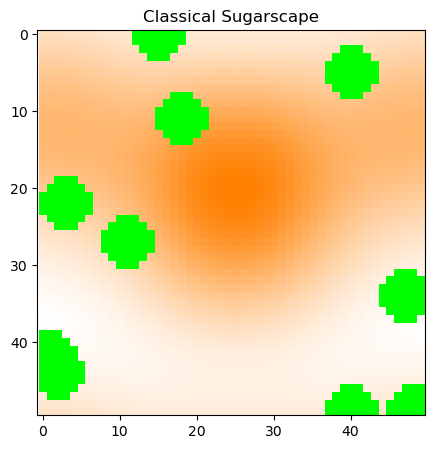

In [39]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.
spot_positions = [(N //1, N // 4),(N //2, N // 3), (N //2, N // 2) ]  # Center of the sugar spots.
spot_widths = [N / 5, N / 5, N/5]  # Width of the sugar spots.
max_sugar = 15  # Maximum sugar level.
I_RGB = np.zeros([N, N, 3])
# Initilazing the sugarscape and pollution map
SuSca = initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar)
pollution_map = create_pollution_map(SuSca, N, 10, 3.5)

# Extracting the boolean values only, for plotting
boolean_pollution_map = np.frompyfunc(lambda x: x[0], 1, 1)(pollution_map).astype(bool)
sugar_pollution_map = np.frompyfunc(lambda x: x[0], 1, 1)(pollution_map).astype(int)

# Create the image of the game outcome.
RGB = {
    'high_sugar': [1.0, 0.5, 0.0],
    'low_sugar': [1.0, 1.0, 1.0],
    'pollution': [0.0, 1.0, 0.0]  # Bright green for pollution
}

SuSca_RGB = convert2RBG(SuSca, RGB, boolean_pollution_map, I_RGB)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


In [40]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

x_positions = np.random.randint(0, N, A)  # Random X positions
y_positions = np.random.randint(0, N, A)  # Random Y positions

max_min_values = {
    'sugar': [10,25],
    'metabolism': [1,5],
    'carrying capacity': [1, 10],
    'vision':[1,10],
    'lifespan': [20, 120],
}

# Create the agents with random attributes between defined integers
# Define the attributes as columns with random values using numpy
agents = pd.DataFrame({
    'metabolism': np.random.randint(*max_min_values['metabolism'], size=A),                  # Random metabolism
    'carrying capacity': np.random.randint(*max_min_values['carrying capacity'], size=A),    # Carrying capacity
    'vision': np.random.randint(*max_min_values['vision'], size=A),                          # Random vision
    'lifespan': np.random.randint(*max_min_values['lifespan'], size=A),                      # Random lifespan
    'pollution_count': np.zeros(A, dtype=int),                                               # Initialize pollution count to 0
    'pollution_factor': np.zeros(A),                                                         # Initialize pollution factor to 0
    'origin': np.arange(A),                                                                  # Sequential origin IDs
    'sugar': np.random.randint(*max_min_values['sugar'], size=A),                            # Random sugar levels
    'age': np.zeros(A, dtype=int),                                                           # Initialize age to 0
    'fitness': np.zeros(A),                                                                  # Initialize fitness to 0
    'x': x_positions,                                                                        # X-coordinates
    'y': y_positions                                                                         # Y-coordinates
})

crossover_genes = ['metabolism','vision', 'lifespan', 'carrying capacity', 'pollution_factor', 'age', 
                    'origin'] 

# Lists to store data from every step
iterations = []
num_agents = []
avg_metabolism = []
avg_carry = []
avg_vision = []
avg_age = []
avg_sugar = []
num_polluted_agents = []
# plot = {
#    'All agents': pd.DataFrame(agents.mean()).T,
#    'Healthy agents': pd.DataFrame(agents.mean()).T,
#    'Polluted agents': pd.DataFrame(agents.mean()*0).T,
# }

# n_plot = {
#    'All agents': [len(agents.copy())],
#    'Healthy agents': [len(agents.copy())],
#    'Polluted agents': [0],
# }

In [41]:
def increase_metabolism_exponentially(agents, step, growth_rate=0.00000001):
    """
    Gradually increase metabolism for each agent with exponential growth.
    
    Parameters:
    agents : pandas DataFrame
        The agents dataframe containing agent attributes.
    step : int
        The current step of the simulation.
    growth_rate : float
        The base rate of exponential growth.
    """
    # Exponential growth of metabolism
    agents['metabolism'] *= np.exp(growth_rate * step)

    
    return agents


In [42]:


def fluctuate_metabolism_periodically(agents, step, period=100, max_fluctuation=0.05):
    """
    Periodically fluctuate metabolism of the agents using a sinusoidal function.
    
    Parameters:
    agents : pandas DataFrame
        The agents dataframe containing agent attributes.
    step : int
        The current step of the simulation.
    period : int
        The period of the fluctuation cycle, the time it takes to complete one full fluctuation (higher = slower).
    max_fluctuation : float
        The maximum fluctuation amplitude that can be applied to metabolism at each step.
    """
    # Sinusoidal fluctuation of metabolism (periodic)
    fluctuation = np.sin(2 * np.pi * step / period) * max_fluctuation
    
    # Apply the fluctuation to the metabolism of all agents
    agents['metabolism'] += fluctuation
    
    # Ensure metabolism stays within the defined bounds
    agents['metabolism'] = agents['metabolism'].clip(lower=max_min_values['metabolism'][0], 
                                                      upper=max_min_values['metabolism'][1])
    
    return agents



In [43]:
import time
from tkinter import Tk
from tkinter import Canvas
import numpy as np

apply_GA = 1 # Apply GA logic after number of steps
N_skip = 1
MAX_STEP = 10000
step = 0

# Visualize status every N_skip steps. 
window_size = 600


tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
canvas.place(x=10, y=10, height=window_size, width=window_size)

running = True
while running:
    # Move agents
    SuSca, agents = move_agents(SuSca, agents, N, boolean_pollution_map, sugar_pollution_map)  # Move the agents on the sugarscape.


    agents['age'] += 1                                              #increase the age of the agents. 
    agents = agents[agents['age'] < agents['lifespan']]             # Remove agents that have reached their lifespan
    
    # calculate the agents new fitness
    agents['fitness'] = agents.apply(calculate_fitness, axis=1) 
    #agents = increase_metabolism_exponentially(agents, step)  # Increase metabolism of agents exponentially 
    agents = fluctuate_metabolism_periodically(agents, step)  # Increase metabolism of agents periodically
    # # # Update animation frame.
    if step % N_skip == 0:
        update_canvas(SuSca, agents, canvas, N, window_size, step, tk, boolean_pollution_map, I_RGB)

    # Save data for plots
    if step % 1 == 0:  # Save data every n steps
        iterations.append(step)
        num_polluted_agents.append(len(agents[agents['pollution_factor'] > 0])/len(agents))  # Antalet förorenade agenter
        num_agents.append(len(agents))  # Antalet agenter (kan förändras under simuleringen)
        avg_metabolism.append(agents["metabolism"].mean())  # Medelvärde av metabolism
        avg_carry.append(agents["carrying capacity"].mean())  # Medelvärde av metabolism
        avg_vision.append(agents["vision"].mean())  # Medelvärde av vision
        avg_age.append(agents["age"].mean())
        avg_sugar.append(agents["sugar"].mean())    
    
     
    # after some steps, apply the GA logic
    if step > apply_GA:
        if step % 1 == 0:
            parents = select_parents(agents, 10)
            new_agents = []
            for i in range(0, len(parents), 2):
                parent1 = parents.iloc[i]
                parent2 = parents.iloc[i + 1]
                child1, child2 = crossover(parent1, parent2, max_min_values, crossover_genes)
                child1 = mutate(child1, max_min_values)
                child2 = mutate(child2, max_min_values)
                new_agents.append(child1)
                new_agents.append(child2)
            agents = replace_population(agents, pd.DataFrame(new_agents))  # Keeping the old agents and adding the new ones to the population --> Population size grows each round

    
    # Periodically regenerate sugar hotspots, simulating inflation in the society? 
    if step % 80 == 0: 
        SuSca = regenerate_hotspots(SuSca, N=50, num_hotspots=4, max_sugar=100, peak_value=100, sigma=4)

    step += 1 

    if step == MAX_STEP:
        running = False 
    
    

    # agents_healthy = agents[agents['pollution_factor'] == 0]
    # agents_polluted = agents[agents['pollution_factor'] > 0]

    # # all_agents = pd.concat([all_agents, agents.mean().T],ignore_index=True)
    # plot['All agents'] = pd.concat([plot['All agents'], agents.mean().to_frame().T])
    # plot['Healthy agents'] = pd.concat([plot['Healthy agents'], agents_healthy.mean().to_frame().T])
    # plot['Polluted agents'] = pd.concat([plot['Polluted agents'], agents_polluted.mean().to_frame().T])

    # n_plot['All agents'].append(len(agents))
    # n_plot['Healthy agents'].append(len(agents_healthy))
    # n_plot['Polluted agents'].append(len(agents_polluted))


tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish).


/var/folders/zq/yh_k39cj0j5_89c5hk05fxf40000gn/T/ipykernel_60231/1740599871.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.996860474023534' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  agents.at[i, "sugar"] -= metabolism


TclError: invalid command name ".!canvas"

In [44]:
agents.to_csv('agents.csv', index=False)

# Save results in a pandas dataframe
abilities_results = pd.DataFrame({
    'metabolism': avg_metabolism,
    'carrying capacity': avg_carry,
    'vision': avg_vision,
    'age': avg_age,
    'sugar': avg_sugar,
    'pollution' : num_polluted_agents}) 

abilities_results.to_csv('results_sugar.csv', index=False)


In [45]:
abilities_results = pd.read_csv('results_sugar.csv')


In [46]:
# import matplotlib.pyplot as plt

# colors = ['r', 'g','teal','orange','darkgreen']

# prop_to_visualize = ['metabolism','carrying capacity','vision','age','sugar']

# # print(len(abilities_results))
# # print(len(num_agents))
# # print(len(iterations))

# plt.figure()
# for key in n_plot.keys():
#     plt.plot(iterations, n_plot[key], label='{key}')

# plt.title(f'Number of agents over {len(iterations)} iterations')
# plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
# plt.xlabel('Iterations')
# plt.ylabel('Number of agents')
# plt.show()


# for prop in prop_to_visualize:
#     plt.figure()
#     for key in plot.keys():
#         plt.plot(iterations, plot[key][prop])
#     plt.title(f'Average {prop} over {len(iterations)} iterations') 
#     plt.xlabel('Iterations')
#     plt.ylabel(f'Average {prop}')
#     plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
#     plt.legend()
#     plt.show()

44
44
44


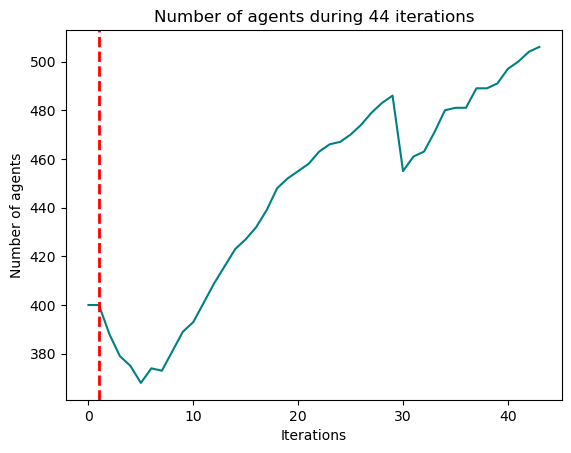

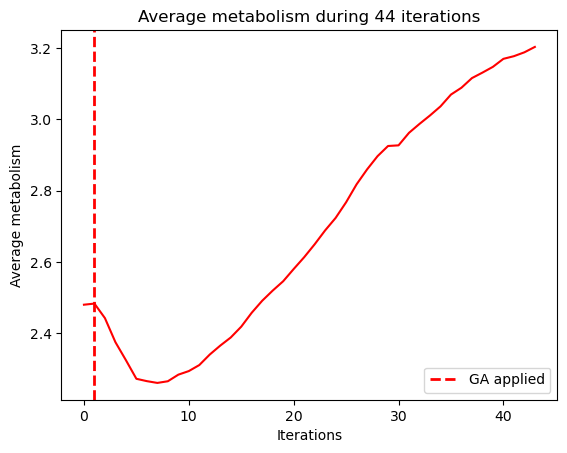

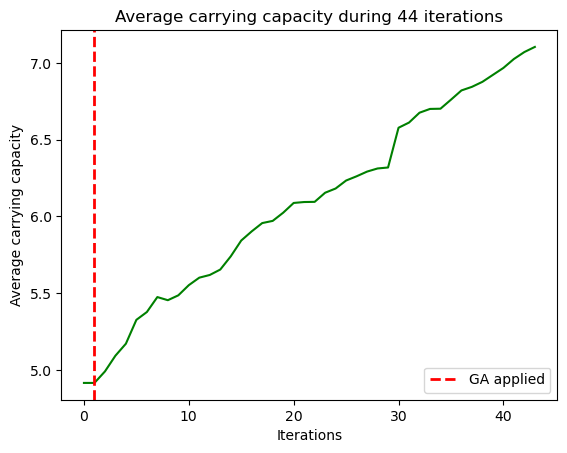

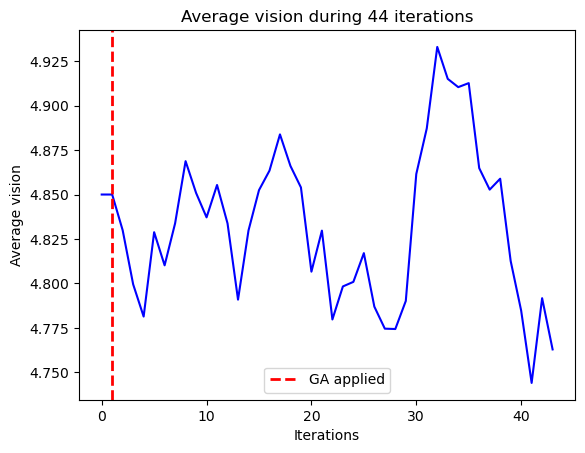

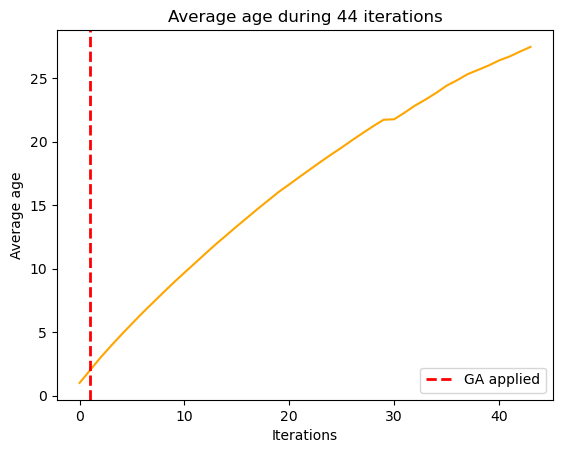

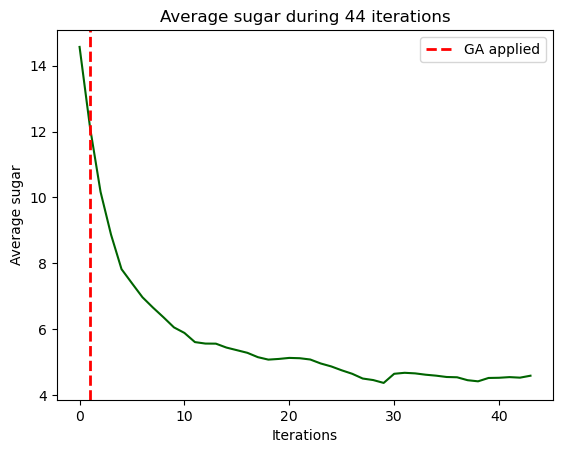

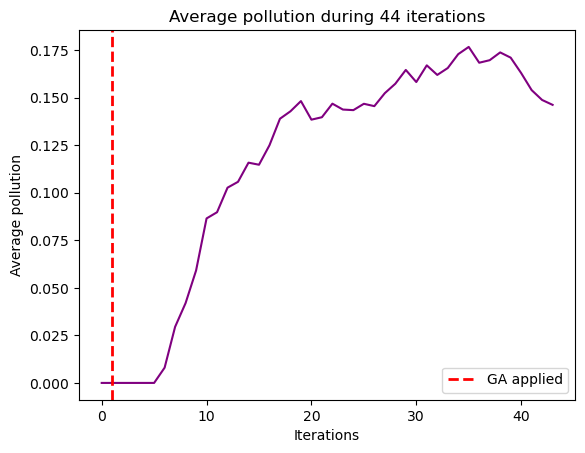

In [47]:
import matplotlib.pyplot as plt

colors = ['r', 'g', 'b', 'orange', 'darkgreen', 'purple', 'pink', 'brown', 'cyan', 'magenta']


print(len(abilities_results))
print(len(num_agents))
print(len(iterations))

plt.figure()
plt.plot(iterations, num_agents, color= 'teal')
plt.title(f'Number of agents during {len(iterations)} iterations')
plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
plt.xlabel('Iterations')
plt.ylabel('Number of agents')
plt.show()

plt.figure()
for ability in range(abilities_results.shape[1]):
    colomn_name = abilities_results.columns[ability]
    plt.plot(iterations,abilities_results[colomn_name], color= colors[ability])
    plt.title(f'Average {colomn_name} during {len(iterations)} iterations') 
    plt.xlabel('Iterations')
    plt.ylabel(f'Average {colomn_name}')
    plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
    plt.legend()
    plt.show()

Ändrade fitness (endast socker)
La till alla properties i crossover/mutation 
Fixade en max_min_values array, lättare att ha koll på ranges

Hur skall vi ha mutation? två funktioner eller samma?